# Network curation from PubMed extracts

In [1]:
sent = "SATB1 also targets ACF1 and ISWI, subunits of CHRAC and ACF nucleosome mobilizing complexes, to this specific site and regulates nucleosome positioning over seven kilobases."
print (len(sent.split(" ")))

25


In [1]:
import warnings
warnings.filterwarnings("ignore")
import spacy
import scispacy
nlp = spacy.load("en_ner_jnlpba_md")

In [97]:
doc = nlp(sent) # essential to re-run everytime

In [98]:
for ent in doc.ents:
    print (ent, len(ent), len(ent.text.split()))

SATB1 1 1
ACF1 1 1
ISWI 1 1
CHRAC 1 1
ACF nucleosome mobilizing complexes 4 4


In [99]:
# Helper functions to get the span 
# from a tokenized sentence for entity 
# longer than 1 word

def pos_dict(doc):
    """ obtain a list of tokens with index """
    pos_index = 0
    token_dict = dict()
    for token in doc:
        token_dict[pos_index] = token.text
        pos_index+=1
    return token_dict

def retrievePOS(ent, token_dict):
    """ return the start and end position for Len(ent)>1 """
    tokens = ent.text.split(" ")
    #print (tokens)
    new_dict = dict(zip(token_dict.values(),token_dict.keys()))
    return (new_dict[tokens[0]],new_dict[tokens[-1]]+1)

def retokenize_ent(doc):
    """ retokenize entity with len(ent)>1 """
    token_dictionary = pos_dict(doc)
    ent_pos = dict()
    for ent in doc.ents:
        ent_pos[ent] = retrievePOS(ent,token_dictionary)
    return ent_pos

In [100]:
# Testing if above helper functions work properly
lst = retokenize_ent(doc) # run this after re-run the doc=nlp(text)
print (lst)

{SATB1: (0, 1), ACF1: (3, 4), ISWI: (5, 6), CHRAC: (9, 10), ACF nucleosome mobilizing complexes: (11, 15)}


In [101]:
for ent, pos in lst.items(): # do it after the re-run
    print (ent.text)
    with doc.retokenize() as retokenizer:
        retokenizer.merge(doc[pos[0]:pos[1]])

SATB1
ACF1
ISWI
CHRAC
ACF nucleosome mobilizing complexes


In [102]:
for token in doc:
    print (token.text)

SATB1
also
targets
ACF1
and
ISWI
,
subunits
of
CHRAC
and
ACF nucleosome mobilizing complexes
,
to
this
specific
site
and
regulates
nucleosome
positioning
over
seven
kilobases
.


In [103]:
# identify the neighbours of each token
for token in doc:
    print (token.text, "has", [t.text for t in token.rights], "to the right.")
    print (token.text, "has", [t.text for t in token.lefts], "to the left.")
    print (token.text, "has", [t.text for t in token.children], "as chidren.")
    print ("")

SATB1 has [] to the right.
SATB1 has [] to the left.
SATB1 has [] as chidren.

also has [] to the right.
also has [] to the left.
also has [] as chidren.

targets has ['ACF1', ',', 'subunits', 'and', 'regulates', '.'] to the right.
targets has ['SATB1', 'also'] to the left.
targets has ['SATB1', 'also', 'ACF1', ',', 'subunits', 'and', 'regulates', '.'] as chidren.

ACF1 has ['and', 'ISWI'] to the right.
ACF1 has [] to the left.
ACF1 has ['and', 'ISWI'] as chidren.

and has [] to the right.
and has [] to the left.
and has [] as chidren.

ISWI has [] to the right.
ISWI has [] to the left.
ISWI has [] as chidren.

, has [] to the right.
, has [] to the left.
, has [] as chidren.

subunits has ['CHRAC', ',', 'site'] to the right.
subunits has [] to the left.
subunits has ['CHRAC', ',', 'site'] as chidren.

of has [] to the right.
of has [] to the left.
of has [] as chidren.

CHRAC has ['and', 'ACF nucleosome mobilizing complexes'] to the right.
CHRAC has ['of'] to the left.
CHRAC has ['of'

In [104]:
import string
exclude = set(string.punctuation)

In [105]:
# Building links among tokens
head = list()
tail = list()
for i, token in enumerate(doc):
    if token.n_lefts>=1:
        for t in token.lefts:
            if t.text in exclude:
                pass
            else:
                head.append(t.text)
                tail.append(token.text)
    if token.n_rights>=1:
        for t in token.rights:
            if t.text in exclude:
                pass
            else:
                head.append(token.text)
                tail.append(t.text)
    if token.text == "and":  # to create a triplet/clique of the network
        head.append(doc[i-1].text)
        tail.append(doc[i+1].text)
        head.append(doc[i+1].text)
        tail.append(doc[i-1].text)
        head.append(token.text)
        tail.append(doc[i-1].text)
        head.append(token.text)
        tail.append(doc[i+1].text)

In [106]:
data = zip(head,tail)

In [107]:
import pandas as pd

In [108]:
df = pd.DataFrame(data,columns=['head','tail'])

In [109]:
pd.set_option("display.max_rows", 200, "display.max_columns", 6)
df

,head,tail
0,SATB1,targets
1,also,targets
2,targets,ACF1
3,targets,subunits
4,targets,and
5,targets,regulates
6,ACF1,and
7,ACF1,ISWI
8,ACF1,ISWI
9,ISWI,ACF1


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 2 columns):
head    33 non-null object
tail    33 non-null object
dtypes: object(2)
memory usage: 656.0+ bytes


In [111]:
DIR = "/Users/ka-mantse/Google Drive/_My Data Analytics Exercise/Exercise/Cytoscape/"

In [112]:
df.to_csv(DIR+"network.csv",index=False)

In [113]:
df = pd.read_csv(DIR+"network.csv")

In [114]:
df.head()

,head,tail
0,SATB1,targets
1,also,targets
2,targets,ACF1
3,targets,subunits
4,targets,and


In [115]:
import networkx as nx

In [116]:
tuples = list()
for i in range(len(df)):
    tuples.append((df.loc[i, 'head'], df.loc[i, 'tail']))

In [117]:
print (tuples)

[('SATB1', 'targets'), ('also', 'targets'), ('targets', 'ACF1'), ('targets', 'subunits'), ('targets', 'and'), ('targets', 'regulates'), ('ACF1', 'and'), ('ACF1', 'ISWI'), ('ACF1', 'ISWI'), ('ISWI', 'ACF1'), ('and', 'ACF1'), ('and', 'ISWI'), ('subunits', 'CHRAC'), ('subunits', 'site'), ('of', 'CHRAC'), ('CHRAC', 'and'), ('CHRAC', 'ACF nucleosome mobilizing complexes'), ('CHRAC', 'ACF nucleosome mobilizing complexes'), ('ACF nucleosome mobilizing complexes', 'CHRAC'), ('and', 'CHRAC'), ('and', 'ACF nucleosome mobilizing complexes'), ('to', 'site'), ('this', 'site'), ('specific', 'site'), ('site', 'regulates'), ('regulates', 'site'), ('and', 'site'), ('and', 'regulates'), ('regulates', 'positioning'), ('nucleosome', 'positioning'), ('positioning', 'kilobases'), ('over', 'kilobases'), ('seven', 'kilobases')]


In [118]:
G = nx.Graph()

In [119]:
G.add_edges_from(tuples)

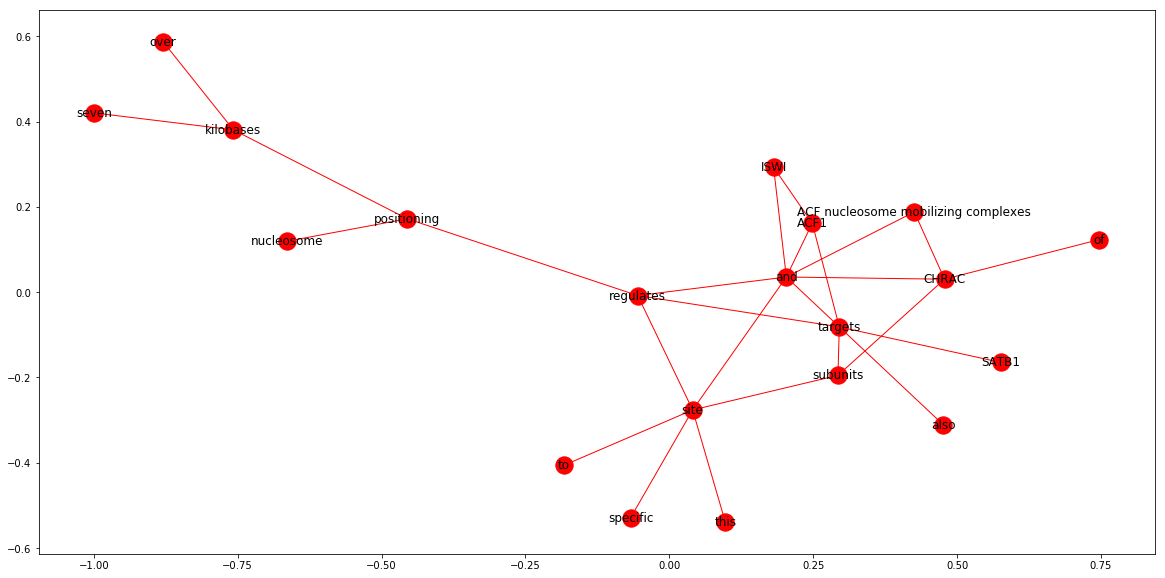

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color='r', with_labels=True)
nx.draw_networkx_labels(G, pos, font_size = 12)
nx.draw_networkx_edges(G, pos, edge_color='b', arrows = True)

plt.show()